In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Autoencoder architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# MNIST Dataloader
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop

for epoch in range(5):
    for batch in train_loader:
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1).to(device)

        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 129MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 37.2MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 33.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.30MB/s]


Epoch 1, Loss: 0.0264
Epoch 2, Loss: 0.0183
Epoch 3, Loss: 0.0141
Epoch 4, Loss: 0.0139
Epoch 5, Loss: 0.0108


Epoch 1, Loss: 146.0310
Epoch 2, Loss: 111.0002
Epoch 3, Loss: 104.7004
Epoch 4, Loss: 101.3404
Epoch 5, Loss: 99.0346


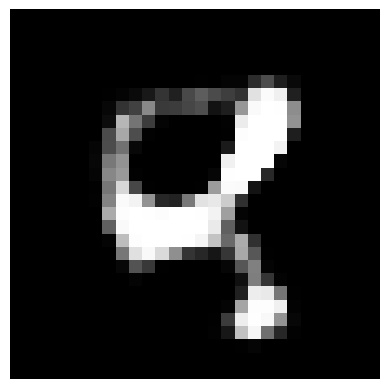

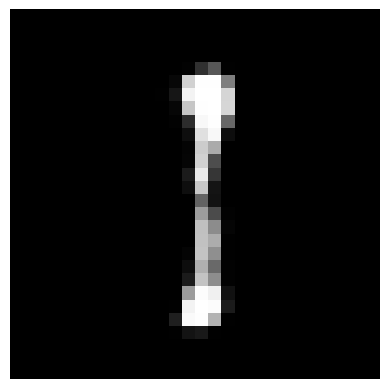

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Variational Autoencoder Model
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(784, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128, bias=True),
            nn.ReLU()
        )

        self.mean = nn.Linear(128, 10, bias=True)
        self.std = nn.Linear(128, 10, bias=True)

        # Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 784, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc = self.Encoder(x)
        mean = self.mean(enc)
        std = self.std(enc)
        z = mean + std * torch.randn_like(std)
        y = self.Decoder(z)
        return mean, std, y.view(-1, 1, 28, 28)

# Loss Function for VAE
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = F.binary_cross_entropy(x_hat.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# Train for one epoch
def train_one_epoch(epoch_index):
    total_loss = 0
    model.train()

    for i, data in enumerate(train_data_loader):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()
        mean, std, outputs = model(inputs.view(-1, 784))
        loss = loss_function(inputs, outputs, mean, std)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch_index+1}, Loss: {total_loss / (len(train_data_loader) * batch_size):.4f}")

# Instantiate model, optimizer
model = VariationalAutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(5):
    train_one_epoch(epoch)

# Generate synthetic digits
def generate_digit():
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        mean = torch.zeros((1, 10)).to(device)
        var = torch.ones((1, 10)).to(device)
        z_sample = mean + var * torch.randn_like(var)
        x_decoded = model.Decoder(z_sample)
        digit = x_decoded.detach().cpu().reshape(28, 28)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')
        plt.show()

# Generate and visualize two digits
generate_digit()
generate_digit()
